**Objetivo**: Treinar uma rede neural convolucional para identificar a presença ou não de células neoplásicas nos tecidos


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

torch.manual_seed(42) # semente aleatoria!!!

plt.ion()   # interactive mode

In [ ]:
def MakeREADME(file_path, text):
  path = file_path+"/README.txt"  # File path and name
  # Open the file in write mode
  file = open(path, "w")
  # Write the text to the file
  file.write(text)
  # Close the file
  file.close()

In [ ]:
# ______________________________________________________________________________
# Cria pasta para salvar resultados do experimento como um todo
import os

ExperimentName = 'Experiment_I'

path_interim = PATH+"Notebooks/InterimResults/{}".format(ExperimentName)
if not os.path.exists(path_interim):
  print('Criar pasta chamada {}? (yes/no)'.format(ExperimentName))
  Answer2 = str (input()) 

  if Answer2=='yes':
    os.mkdir(path_interim)
    print('Resuma o conteudo deste grande experimento. Qual a sua principal diferença para os demais?')
    text = str (input()) 
    MakeREADME(path_interim, text)

# ______________________________________________________________________________
# Cria subdiretorio para salvar resultados dos subexperimentos
print('Quer criar um novo sub_experimento? (True/False)')
NewSubExperiment = str (input())

if NewSubExperiment: 
  Experiment_Number = sum(1 for entry in os.scandir(path_interim) if entry.is_file())
  subpath = path_interim+'/{}'.format(Experiment_Number)
  os.mkdir(subpath)

  print('Resuma o conteudo deste sub experimento. Qual a sua principal mudança feita')
  text = str (input()) 
  MakeREADME(subpath, text)
  
else: 

  print('Diga o numero do experimento que você gostaria de refazer (Experiment_Number)')
  Experiment_Number = str (input())
  subpath = path_interim+'/{}'.format(Experiment_Number)

Criar pasta chamada Experiment_I? (yes/no)
yes
Resuma o conteudo deste grande experimento. Qual a sua principal diferença para os demais?
Experimento em que usaremos as imagens de todos os tecidos para o treinamento menos o Breast, que será usado para os testes. \n O modelo consiste na EfficientNet_B0 com Transfer Learning. \n Também são usadas as técnicas de Data Augmentation. 
Quer criar um novo sub_experimento? (True/False)
True
Resuma o conteudo deste sub experimento. Qual a sua principal mudança feita
Uso da EfficientNet_b0 com transfer learning e data augmentation (Flips, erases e pad).)


# Configurações gerais e funções úteis para as análises

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd

def AnalysisPlots(classe_teste, PrevisoesProb):

  # Construindo a ROC Curve
  # A função abaixo retorna arrays de True Positive Rate (TPR), False Positive Rate (FPR) e os valores de threshold
  FPR, TPR, thresholds = metrics.roc_curve(classe_teste, PrevisoesProb, drop_intermediate=False) 

  # Calculo da AUC
  auc = metrics.roc_auc_score(classe_teste, PrevisoesProb) 

  # Plotando ROC Curve com matplotlib:
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(FPR, TPR, label="AUC ="+np.format_float_positional(auc, precision=3))
  ax.plot([0,1], [0,1], linestyle='--', label='Random Selection, AUC = 0.5')
  ax.set_xlabel('False Positive Rate', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('ROC Curve', fontsize=15)
  ax.grid()
  ax.legend(loc='lower right')
  plt.savefig(subpath+'/ROCCurve.png')
  #plt.show()

  plt.clf() # limpando janela de plot

  # Plot TPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, TPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('TPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(subpath+'/TPRxThresholf.png')
  #plt.show()

  plt.clf() # limpando janela de plot

  # Plot FPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, FPR)
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('False Positive Rate', fontsize=15)
  ax.set_title('FPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  #plt.show()

  # Comando para salvar figura:
  plt.savefig(subpath+'/FPRxThresholf.png')

  plt.clf() # limpando janela de plot

  # Dataframe com indice de Youden:
  DataFrameYouden = pd.DataFrame(data={'Threshold':thresholds,'Youden':TPR - FPR})

  # Dataframe com indice maximo de Youden:
  DataFrameYoudenMax = DataFrameYouden.sort_values(by='Youden', ascending = False) # Ordenando em ordem crescente

  # Print do valor de threshold que maximiza o índice de Youden:
  print('\n Melhor Decision Threshold: ', DataFrameYoudenMax.Threshold.values[0]) # printando valor de threshold que maximiza o Youden
  print('\n Melhor Índice de Youden: ', DataFrameYoudenMax.Youden.values[0]) # printando valor maximo do Youden


def Variable_x_Epochs(Epochs, Variable1, Variable2, metricname):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(Epochs, Variable1, label='Train')
  ax.plot(Epochs, Variable2, label='Val')
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('{}'.format(metricname), fontsize=15)
  plt.legend()
  ax.grid()
  plt.savefig(subpath+'/Epochsx{}.png'.format(metricname))
  plt.show()

## Carregar dados


In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

## Treinando o modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    LOSS_train = []
    LOSS_val = []
    ACC_train = []
    ACC_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    best_epoch = 0
    best_acc = 0
    best_auc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            Probabilities = []
            ClassLabels = []

            BatchTotalSize = len(dataloaders[phase])

            batch_counter = 0
            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        batch_counter = batch_counter + 1
                        print('\r Steps: {} out {}'.format(batch_counter, BatchTotalSize), end=" ")
                        loss.backward()
                        optimizer.step()

                Probabilities.append(outputs.cpu().detach().numpy()[:,1])
                ClassLabels.append(labels.cpu().detach().numpy())

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            
            ClassLabels = np.concatenate(ClassLabels).ravel()
            Probabilities = np.concatenate(Probabilities).ravel()

            #print('labels', ClassLabels)
            #print('probs', Probabilities)
                
            if phase == 'train' and scheduler!=None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_auc = metrics.roc_auc_score(ClassLabels, Probabilities) 

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))

            # deep copy the model 
            if phase == 'val' and epoch_loss < best_loss: # criterio de minimizacao do loss
                print('Best model detected!')
                best_loss = epoch_loss
                best_auc = epoch_auc
                best_acc = epoch_acc
                best_epoch = epoch

                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc.cpu().detach().numpy())
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc.cpu().detach().numpy())
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model (epoch={}): val Loss: {:5f} Acc: {:5f} val AUC: {:5f}'.format(best_epoch, best_loss, best_acc, best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, LOSS_train, ACC_train, LOSS_val, ACC_val


## Testando o modelo

In [ ]:
def validate_model(model):
    model.eval()

    Probabilities = []
    ClassLabels = []

    with torch.no_grad():

            # Iterate over data.
            for inputs, labels, _ in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                Probabilities.append(outputs.cpu().detach().numpy()[:,1])
                ClassLabels.append(labels.cpu().detach().numpy())

    return np.concatenate(Probabilities).ravel(), np.concatenate(ClassLabels).ravel()

# Experimento:



In [ ]:
# Data augmentation and normalization for training

data_dir = PATH+'Datasets/Processed/Experiment_I'

size, padding = 224, 30 # tamanho de entrada da EfficientNet B1

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Pad(padding),
        transforms.RandomCrop(size, padding),
        transforms.ToTensor(), 
        transforms.RandomErasing(p=0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)

{'train': 3886, 'val': 1652}


In [ ]:
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)

# Add a softmax activation to the output layer
model = nn.Sequential(model, nn.Softmax(dim=1))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

num_epochs = 40 # epochs
lr=1e-4 # learning rate

# Observe that all parameters are being optimized
optimizer_model = optim.Adam(model.parameters(), lr=lr)

summary(model, (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
print("Hyperparameters Summary \n")
print("Learning Rate: ", lr)
print("Optmizer: ADAM")
print("Loss Function: Binary Cross Entropy")
print("N Epochs: ", num_epochs)

Hyperparameters Summary 

Learning Rate:  0.0001
Optmizer: ADAM
Loss Function: Binary Cross Entropy
N Epochs:  40


In [ ]:
model, LOSS_train, ACC_train, LOSS_val, ACC_val = train_model(model, criterion, optimizer_model,
                       num_epochs=num_epochs)

# Saving model
PATH = subpath+'/Trained_DLModel.pt'
torch.save(model.state_dict(),PATH)

Epoch 0/39
----------
 Steps: 243 out 243 train Loss: 0.5119 Acc: 0.8078 AUC: 0.8834
val Loss: 0.4429 Acc: 0.8650 AUC: 0.9419
Best model detected!
Epoch 1/39
----------
 Steps: 243 out 243 train Loss: 0.4411 Acc: 0.8693 AUC: 0.9344
val Loss: 0.4147 Acc: 0.8971 AUC: 0.9519
Best model detected!
Epoch 2/39
----------
 Steps: 243 out 243 train Loss: 0.4328 Acc: 0.8747 AUC: 0.9417
val Loss: 0.4102 Acc: 0.8983 AUC: 0.9573
Best model detected!
Epoch 3/39
----------
 Steps: 243 out 243 train Loss: 0.4137 Acc: 0.8976 AUC: 0.9512
val Loss: 0.4086 Acc: 0.9031 AUC: 0.9542
Best model detected!
Epoch 4/39
----------
 Steps: 243 out 243 train Loss: 0.4193 Acc: 0.8927 AUC: 0.9475
val Loss: 0.3932 Acc: 0.9177 AUC: 0.9658
Best model detected!
Epoch 5/39
----------
 Steps: 243 out 243 train Loss: 0.4089 Acc: 0.9025 AUC: 0.9568
val Loss: 0.4022 Acc: 0.9098 AUC: 0.9591
Epoch 6/39
----------
 Steps: 243 out 243 train Loss: 0.4049 Acc: 0.9097 AUC: 0.9587
val Loss: 0.3949 Acc: 0.9165 AUC: 0.9653
Epoch 7/39
--

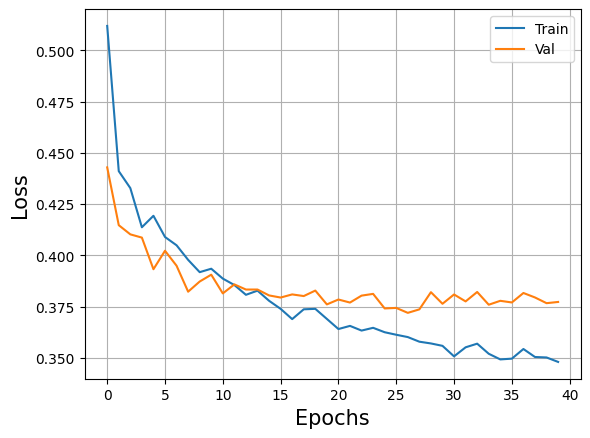

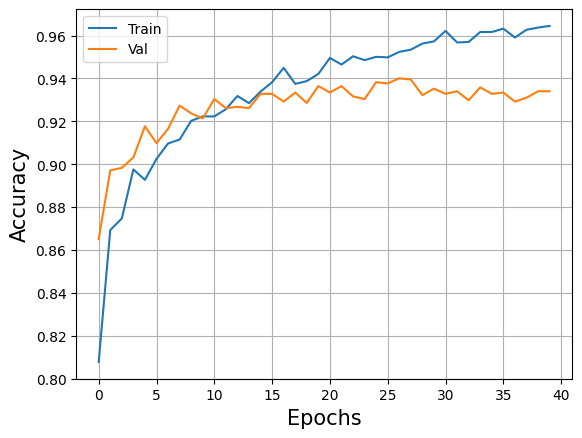

In [ ]:
# Plot curves:
Epochs = np.arange(0,num_epochs)

# Loss Curves:
Variable_x_Epochs(Epochs, LOSS_train, LOSS_val, "Loss")
# Acc Curves:
Variable_x_Epochs(Epochs, ACC_train, ACC_val, "Accuracy")

In [ ]:
# Plot das curvas de TPR e FPR em função do Decision Threshold:

Predictions, classes = validate_model(model)
AnalysisPlots(classes, Predictions)


 Melhor Decision Threshold:  0.93738544

 Melhor Índice de Youden:  0.88751299078755


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Saving a copy of the experiment notebook
import shutil

source_file = '/content/gdrive/Shareddrives/IA901 - Projeto Final/Notebooks/02_TrainDL.ipynb'

# Copy the file to the destination directory
shutil.copy2(source_file, subpath)

'/content/gdrive/Shareddrives/IA901 - Projeto Final/Notebooks/InterimResults/Experiment_I/3/02_TrainDL.ipynb'